<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Stimulus_effects_variability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- 1️⃣ Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- 2️⃣ Clone GitHub repo (contains src/NPI.py) ---
!rm -rf /content/BrainStim_ANN_fMRI_HCP
!git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git

# --- 3️⃣ Define paths ---
import os, sys, gc
repo_dir    = "/content/BrainStim_ANN_fMRI_HCP"
data_dir    = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
preproc_dir = os.path.join(data_dir, "preprocessed_subjects")
models_dir  = os.path.join(preproc_dir, "trained_models_MLP")
ects_dir    = os.path.join(preproc_dir, "ECts_MLP")
os.makedirs(ects_dir, exist_ok=True)

if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# --- 4️⃣ Imports ---
import numpy as np
from scipy import stats
import torch
import torch.serialization
from src import NPI

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Repo loaded from:", repo_dir)
print("Using device:", device)

# --- 5️⃣ Choose which subjects to process ---
# either specify manually:
#subjects = ["id_100206"]
# or automatically detect all
subjects = sorted({fn.split("_signals.npy")[0]
                   for fn in os.listdir(preproc_dir)
                   if fn.endswith("_signals.npy")})

Mounted at /content/drive
Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 167 (delta 46), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (167/167), 24.35 MiB | 12.36 MiB/s, done.
Resolving deltas: 100% (46/46), done.
✅ Repo loaded from: /content/BrainStim_ANN_fMRI_HCP
Using device: cpu


In [2]:
# ============================================
# 📦 Load EC_t and X for all subjects
# ============================================

ECts = {}   # will hold EC_t arrays per subject
Xs   = {}   # will hold input X arrays per subject

for sid in subjects:
    ECt_path = os.path.join(ects_dir, f"{sid}_ECt.npy")
    X_path   = os.path.join(preproc_dir, f"{sid}_inputs.npy")

    if not os.path.exists(ECt_path):
        print(f"⚠️ Skipping {sid}: EC_t file not found.")
        continue
    if not os.path.exists(X_path):
        print(f"⚠️ Skipping {sid}: inputs file not found.")
        continue

    ECts[sid] = np.load(ECt_path)
    Xs[sid]   = np.load(X_path)

    print(f"✅ Loaded {sid}: EC_t {ECts[sid].shape}, X {Xs[sid].shape}")

print(f"\n🎯 Loaded {len(ECts)} subjects successfully.")

✅ Loaded id_100206: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_100307: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_100408: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_101006: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_101107: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_101309: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_101915: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_102008: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_102109: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_102311: EC_t (500, 450, 450), X (4677, 1350)

🎯 Loaded 10 subjects successfully.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==============================================================
# 🔹 Variability analysis across subjects
# ==============================================================

def variability_cosine(effects: np.ndarray) -> float:
    """1 - mean cosine similarity across time samples (higher = more variable)."""
    if effects.shape[0] < 2:
        return np.nan
    norms = np.linalg.norm(effects, axis=1, keepdims=True)
    norms = np.where(norms < 1e-12, 1.0, norms)
    Xn = effects / norms
    S = Xn @ Xn.T
    iu = np.triu_indices_from(S, k=1)
    return 1.0 - np.mean(S[iu])

def variability_L2(effects: np.ndarray) -> float:
    """Mean pairwise L2 distance across time samples."""
    if effects.shape[0] < 2:
        return np.nan
    diffs = effects[:, None, :] - effects[None, :, :]
    D = np.linalg.norm(diffs, axis=2)
    iu = np.triu_indices_from(D, k=1)
    return np.mean(D[iu])

# Choose which variability metric to use
var_func = variability_cosine   # or variability_L2

# Fraction of timepoints to keep (10%)
frac = 0.05

results = []   # to collect per-subject summary stats

for sid in ECts.keys():
    EC_t = ECts[sid]
    X = Xs[sid]
    M, N = EC_t.shape[0], EC_t.shape[1]
    S = X.shape[1] // N

    # --- Baseline energy
    x_t = X[:M, :]
    E_t = np.sum(x_t**2, axis=1)
    n_sel = int(frac * M)
    sorted_idx = np.argsort(E_t)
    low_idx  = sorted_idx[:n_sel]
    high_idx = sorted_idx[-n_sel:]
    rng = np.random.default_rng(seed=42)
    rand_idx = rng.choice(M, size=n_sel, replace=False)

    # --- Variability per region
    var_low  = np.zeros(N)
    var_high = np.zeros(N)
    var_rand = np.zeros(N)
    for j in range(N):
        var_low[j]  = var_func(EC_t[low_idx,  j, :])
        var_high[j] = var_func(EC_t[high_idx, j, :])
        var_rand[j] = var_func(EC_t[rand_idx, j, :])

    # --- Subject-level summary
    results.append(dict(
        subj=sid,
        var_low_mean=np.nanmean(var_low),
        var_high_mean=np.nanmean(var_high),
        var_rand_mean=np.nanmean(var_rand),
    ))

    print(f"{sid}: mean var (low/high/rand) = "
          f"{np.nanmean(var_low):.3f} / {np.nanmean(var_high):.3f} / {np.nanmean(var_rand):.3f}")

# --- Combine results
df_var = pd.DataFrame(results)
print("\nSummary (mean across subjects):")
print(df_var[['var_low_mean','var_high_mean','var_rand_mean']].mean())

id_100206: mean var (low/high/rand) = 0.186 / 0.225 / 0.218
id_100307: mean var (low/high/rand) = 0.193 / 0.233 / 0.231
id_100408: mean var (low/high/rand) = 0.141 / 0.178 / 0.196
id_101006: mean var (low/high/rand) = 0.198 / 0.192 / 0.226
id_101107: mean var (low/high/rand) = 0.120 / 0.130 / 0.163
id_101309: mean var (low/high/rand) = 0.174 / 0.182 / 0.230
id_101915: mean var (low/high/rand) = 0.197 / 0.158 / 0.217
id_102008: mean var (low/high/rand) = 0.168 / 0.168 / 0.194
id_102109: mean var (low/high/rand) = 0.141 / 0.139 / 0.193
id_102311: mean var (low/high/rand) = 0.164 / 0.182 / 0.208

Summary (mean across subjects):
var_low_mean     0.168163
var_high_mean    0.178607
var_rand_mean    0.207509
dtype: float64


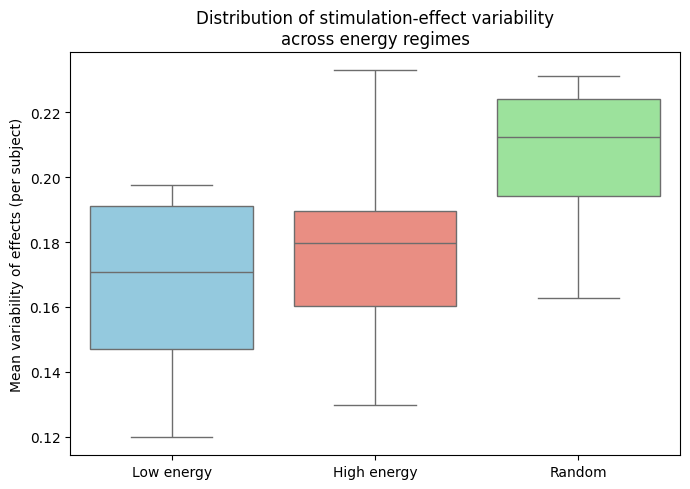

In [13]:
# ==============================================================
# 📊 Visualizations
# ==============================================================

# --- 1️⃣ Distribution across subjects ---
plt.figure(figsize=(7,5))
sns.boxplot(
    data=df_var[['var_low_mean','var_high_mean','var_rand_mean']],
    palette=['skyblue','salmon','lightgreen']
)
plt.xticks([0,1,2], ['Low energy','High energy','Random'])
plt.ylabel('Mean variability of effects (per subject)')
plt.title('Distribution of stimulation-effect variability\nacross energy regimes')
plt.tight_layout()
plt.show()

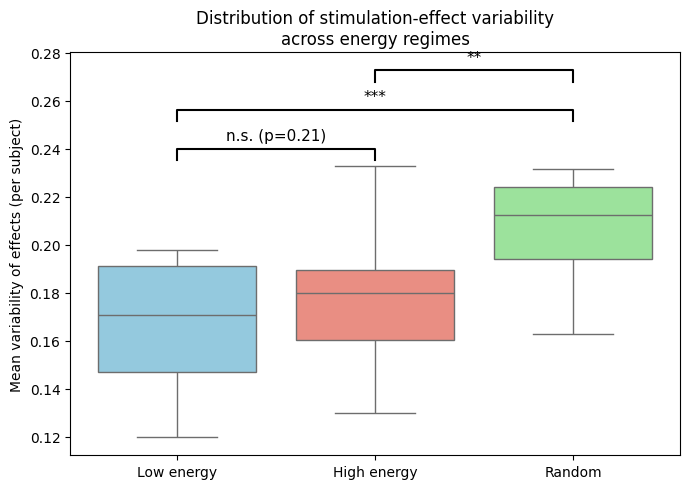

Low vs High:   t=-1.34, p=0.212
Low vs Random: t=-9.83, p=4.13e-06
High vs Random: t=-4.18, p=0.00236


In [16]:
from scipy.stats import ttest_rel, wilcoxon

# ==============================================================
# 📊 Boxplot + statistical comparisons
# ==============================================================

plt.figure(figsize=(7,5))
sns.boxplot(
    data=df_var[['var_low_mean','var_high_mean','var_rand_mean']],
    palette=['skyblue','salmon','lightgreen']
)
plt.xticks([0,1,2], ['Low energy','High energy','Random'])
plt.ylabel('Mean variability of effects (per subject)')
plt.title('Distribution of stimulation-effect variability\nacross energy regimes')
plt.tight_layout()

# --- Statistical tests ---
low = df_var['var_low_mean']
high = df_var['var_high_mean']
rand = df_var['var_rand_mean']

# Paired t-tests (you can switch to wilcoxon if you prefer)
t_low_high, p_low_high = ttest_rel(low, high, nan_policy='omit')
t_low_rand, p_low_rand = ttest_rel(low, rand, nan_policy='omit')
t_high_rand, p_high_rand = ttest_rel(high, rand, nan_policy='omit')

# --- Annotate on plot ---
ymax = max(low.max(), high.max(), rand.max())
y_gap = 0.02 * ymax

def add_sig_line(x1, x2, y, p, label_offset=0.01):
    """Draws a significance bar between two boxes."""
    line_y = y + y_gap
    plt.plot([x1, x1, x2, x2], [y, line_y, line_y, y], lw=1.5, c='k')
    if p < 0.001:
        label = '***'
    elif p < 0.01:
        label = '**'
    elif p < 0.05:
        label = '*'
    else:
        label = f"n.s. (p={p:.2f})"
    plt.text((x1 + x2)/2, line_y + label_offset*ymax, label,
             ha='center', va='bottom', fontsize=11)

# Draw lines
add_sig_line(0, 1, ymax + 0.01*ymax, p_low_high)
add_sig_line(0, 2, ymax + 0.08*ymax, p_low_rand)
add_sig_line(1, 2, ymax + 0.15*ymax, p_high_rand)

plt.show()

# --- Print stats in console for clarity ---
print(f"Low vs High:   t={t_low_high:.2f}, p={p_low_high:.3g}")
print(f"Low vs Random: t={t_low_rand:.2f}, p={p_low_rand:.3g}")
print(f"High vs Random: t={t_high_rand:.2f}, p={p_high_rand:.3g}")


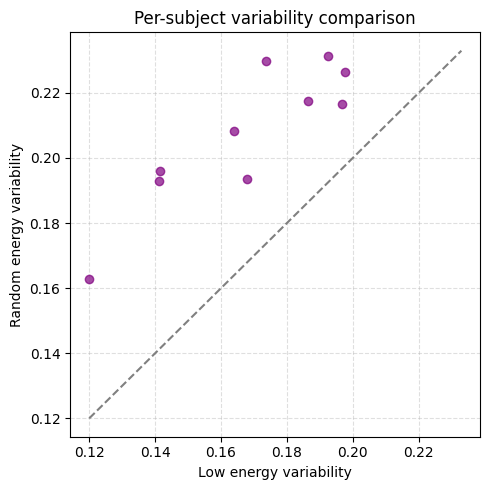

In [14]:
# --- 2️⃣ Paired scatter per subject (low vs high) ---
plt.figure(figsize=(5,5))
plt.plot(df_var['var_low_mean'], df_var['var_rand_mean'],
         'o', color='purple', alpha=0.7)

# Compute numeric range only over numeric columns
num_df = df_var.select_dtypes(include=[np.number])
vmin = 0.12#num_df.min().min()
vmax = num_df.max().max()

plt.plot([vmin, vmax], [vmin, vmax], '--', color='gray')
plt.xlabel('Low energy variability')
plt.ylabel('Random energy variability')
plt.title('Per-subject variability comparison')
plt.grid(ls='--', alpha=0.4)
plt.tight_layout()
plt.show()


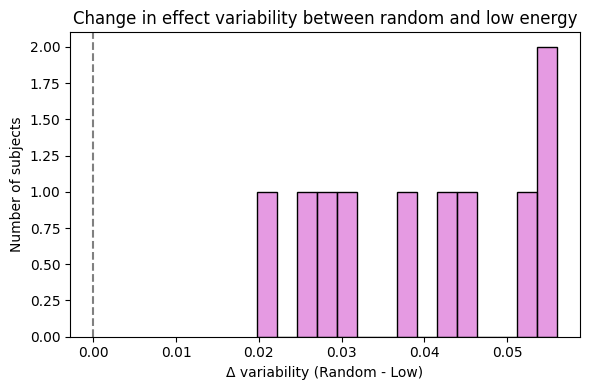

In [15]:
# --- 3️⃣ Optional histogram of Δvar (high - low) ---
df_var['delta'] = df_var['var_rand_mean'] - df_var['var_low_mean']
plt.figure(figsize=(6,4))
sns.histplot(df_var['delta'], bins=15, color='orchid', edgecolor='k', alpha=0.7)
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Δ variability (Random - Low)')
plt.ylabel('Number of subjects')
plt.title('Change in effect variability between random and low energy')
plt.tight_layout()
plt.show()
